# CNN trigger classifier

In this notebook we will investigate the use of CNN models for classifying detector images as triggered event.

In [1]:
# Python 2-3 compatibility
from __future__ import print_function
from __future__ import division

# System imports
import sys
import os
import multiprocessing as mp
from functools import partial

# External imports
import numpy as np
import pandas as pd

# Local imports
from data import process_files, select_barrel_hits, check_data_consistency, bin_barrel_hits

# Plotting
import matplotlib.pyplot as plt

%matplotlib notebook

In [11]:
from keras import layers, models

import keras.backend as K
K.set_image_data_format('channels_first')

from drawing import draw_train_history

Using TensorFlow backend.


## Load the data

In [2]:
# Config
input_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'
n_files = 5
n_workers = 5

all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(input_dir, f) for f in hits_files[:n_files]]
particles_files = sorted(f for f in all_files if f.startswith('particles'))
particles_files = [os.path.join(input_dir, f) for f in particles_files[:n_files]]

In [3]:
%%time

# Load and select data
with mp.Pool(processes=n_workers) as pool:
    hits, particles = process_files(hits_files, particles_files, pool)
    hits = pool.map(select_barrel_hits, hits)

# Safety check
check_data_consistency(hits, particles)

print('Loaded hits data with shapes: %s' % (list(map(np.shape, hits))))
print('Loaded particles data with shapes: %s' % (list(map(np.shape, particles))))

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/particles_10.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/particles_12.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/particles_100.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/particles_11.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/particles_1.csv
All looks ok!
Loaded hits data with shapes: [(327771, 6), (331061, 6), (333361, 6), (332410, 6), (330722, 6)]
Loaded particle

## Construct detector images

In [ ]:
# Detector volumes
vols = [0, 1, 2]
n_vols = len(vols)

# Number of bins defined per volume as (numLayer, numPhi, numZ)
bins = [
    [4, 64, 64],
    [4, 64, 64],
    [2, 64, 21]
]

# Ranges similarly defined per volume as (rangeLayer, rangePhi, rangeZ)
ranges = [
    [[0, 4], [-np.pi, np.pi], [-500, 500]],
    [[4, 8], [-np.pi, np.pi], [-1080, 1080]],
    [[8, 10], [-np.pi, np.pi], [-1031, 1031]]
]

In [6]:
%%time

evtids = [h.evtid.unique() for h in hits]
bin_func = partial(bin_barrel_hits, vols=vols, bins=bins, ranges=ranges)
with mp.Pool(processes=n_workers) as pool:
    hists = pool.starmap(bin_func, zip(hits, evtids))

# Now combine all the data
evtids = np.concatenate(evtids)
hits = pd.concat(hits)
particles = pd.concat(particles)
hists = [np.concatenate([h[iv] for h in hists]) for iv in range(n_vols)]

CPU times: user 323 ms, sys: 707 ms, total: 1.03 s
Wall time: 5.78 s


In [7]:
# Print the final shapes
print('Hits:', hits.shape)
print('Particles:', particles.shape)
print('Images:')
for h in hists:
    print(' ', h.shape)

Hits: (1655325, 6)
Particles: (215925, 6)
Images:
  (4988, 4, 64, 64)
  (4988, 4, 64, 64)
  (4988, 2, 64, 21)


## Trigger target

We will use the following truth-based algorithm to label samples:
- select tracks that hit at least 7 barrel detector layers
- events pass if there are 3 such tracks with pt > 2 GeV

In [8]:
def trigger_event(x, layers=7, pt=2, tracks=3):
    return ((x.nlayer >= layers) & (x.pt > pt)).sum() >= tracks

In [9]:
%%time

# Compute number of layers hit for each truth particle
join_keys = ['evtid', 'barcode']
nlayer = (hits.groupby(join_keys).apply(lambda x: len(x.layer.unique()))
          .reset_index(name='nlayer'))
pars = particles.merge(nlayer, on=join_keys)

# Compute the trigger decision labels
trigger_results = pars.groupby('evtid').apply(trigger_event)

CPU times: user 36.3 s, sys: 157 ms, total: 36.4 s
Wall time: 36.4 s


In [10]:
labels = trigger_results.loc[evtids].values

## CNN classifier model

Now we define the model which will classify events according to the trigger decision.

In [12]:
def build_cnn_model(input_shapes):

    # Inputs for each detector volume
    in0 = layers.Input(shape=input_shapes[0])
    in1 = layers.Input(shape=input_shapes[1])
    in2 = layers.Input(shape=input_shapes[2])

    # CNN module for volume 0
    conv_args = dict(padding='same', activation='relu')
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(in0)
    h0 = layers.MaxPool2D((2, 2))(h0)
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(h0)
    h0 = layers.MaxPool2D((2, 2))(h0)
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(h0)
    h0 = layers.MaxPool2D((2, 2))(h0)
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(h0)
    h0 = layers.MaxPool2D((2, 2))(h0)

    # CNN module for volume 1
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(in1)
    h1 = layers.MaxPool2D((2, 2))(h1)
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(h1)
    h1 = layers.MaxPool2D((2, 2))(h1)
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(h1)
    h1 = layers.MaxPool2D((2, 2))(h1)
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(h1)
    h1 = layers.MaxPool2D((2, 2))(h1)

    # CNN module for volume 2
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(in2)
    h2 = layers.MaxPool2D((2, 2))(h2)
    h2 = layers.ZeroPadding2D((0, 1))(h2)
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(h2)
    h2 = layers.MaxPool2D((2, 2))(h2)
    h2 = layers.ZeroPadding2D((0, 1))(h2)
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(h2)
    h2 = layers.MaxPool2D((2, 2))(h2)
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(h2)
    h2 = layers.MaxPool2D((2, 1))(h2)

    # Combine the modules and final layers
    hout = layers.concatenate([h0, h1, h2], axis=1)
    hout = layers.Conv2D(8, (4, 4), padding='valid', activation='relu')(hout)
    hout = layers.Flatten()(hout)
    hout = layers.Dense(1, activation='sigmoid')(hout)

    # Compile the model
    model = models.Model(inputs=[in0, in1, in2], outputs=hout)
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Train the model

In [13]:
# Training config
batch_size = 32
n_epochs = 10
val_frac = 0.2

In [ ]:
model = build_cnn_model(bins)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 2, 64, 21)     0                                            
____________________________________________________________________________________________________
conv2d_9 (Conv2D)                (None, 8, 64, 21)     152         input_3[0][0]                    
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 4, 64, 64)     0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 4, 64, 64)     0                                            
___________________________________________________________________________________________

In [ ]:
history = model.fit(hists, labels, batch_size=batch_size,
                    epochs=n_epochs, validation_split=val_frac)

Train on 3990 samples, validate on 998 samples
Epoch 1/10
3990/3990 [==============================] - 71s - loss: 0.4413 - acc: 0.7805 - val_loss: 0.3850 - val_acc: 0.8176
Epoch 2/10
3990/3990 [==============================] - 71s - loss: 0.3685 - acc: 0.8316 - val_loss: 0.3614 - val_acc: 0.8277
Epoch 3/10
3990/3990 [==============================] - 71s - loss: 0.3613 - acc: 0.8353 - val_loss: 0.3612 - val_acc: 0.8287
Epoch 4/10
3990/3990 [==============================] - 71s - loss: 0.3456 - acc: 0.8444 - val_loss: 0.3532 - val_acc: 0.8427
Epoch 5/10
3990/3990 [==============================] - 72s - loss: 0.3364 - acc: 0.8519 - val_loss: 0.3730 - val_acc: 0.8186
Epoch 6/10
3990/3990 [==============================] - 75s - loss: 0.3241 - acc: 0.8536 - val_loss: 0.3511 - val_acc: 0.8377
Epoch 7/10
  64/3990 [..............................] - ETA: 67s - loss: 0.3188 - acc: 0.8906

<IPython.core.display.Javascript object>


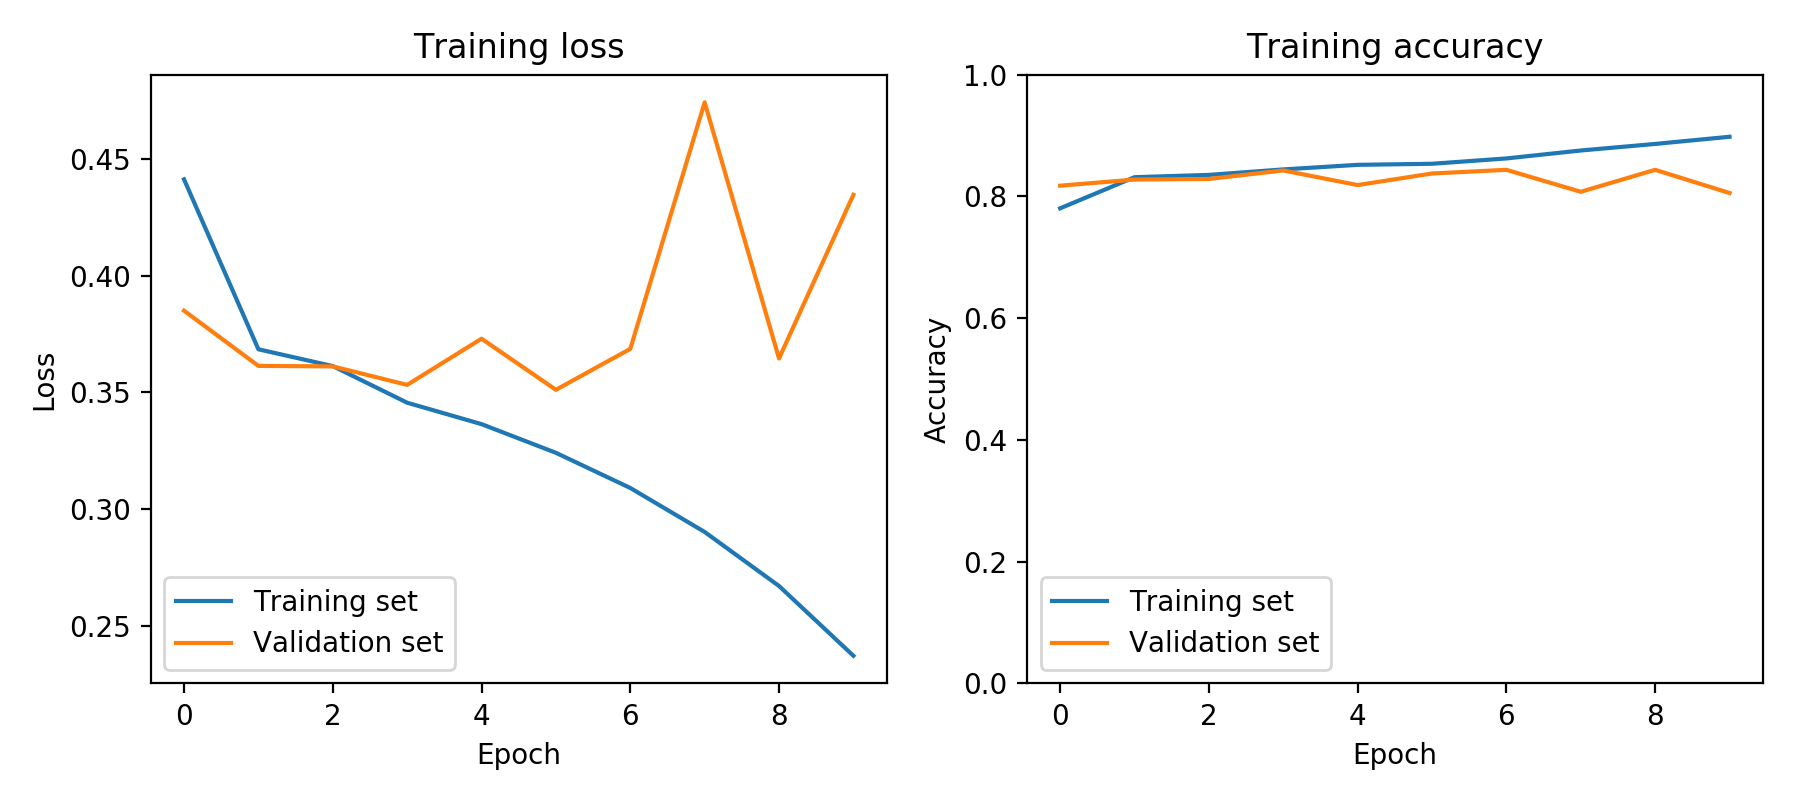

In [18]:
fig = draw_train_history(history, figsize=(9,4))

## Discussion

The model performance here seemed to plateau fairly quickly and then overfit.
It could be that
- the images are too coarse
- I didn't train on enough data
- the model is too deep (hard to avoid with highly aggressive down-sampling)